# Multi-Head Attention

Multi-Head Attention is an important part of all Transformer-based models.
This tutorial will show how to write it and how to then optimize it.

Let's start with an overview on BERT model architecture, where the main building block is Transfomrer Encoder, whcih in turn has the main block Multi-Head Attention (MHA)

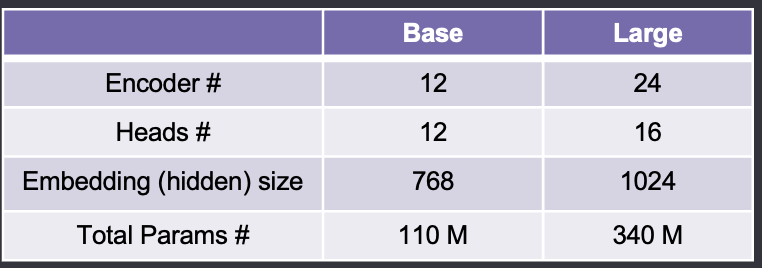

In [1]:
# BERT model architecture and size
from IPython.display import Image
Image(filename='bert_table_1.png', width=400)

### MHA overview: Tensor processing and shaping

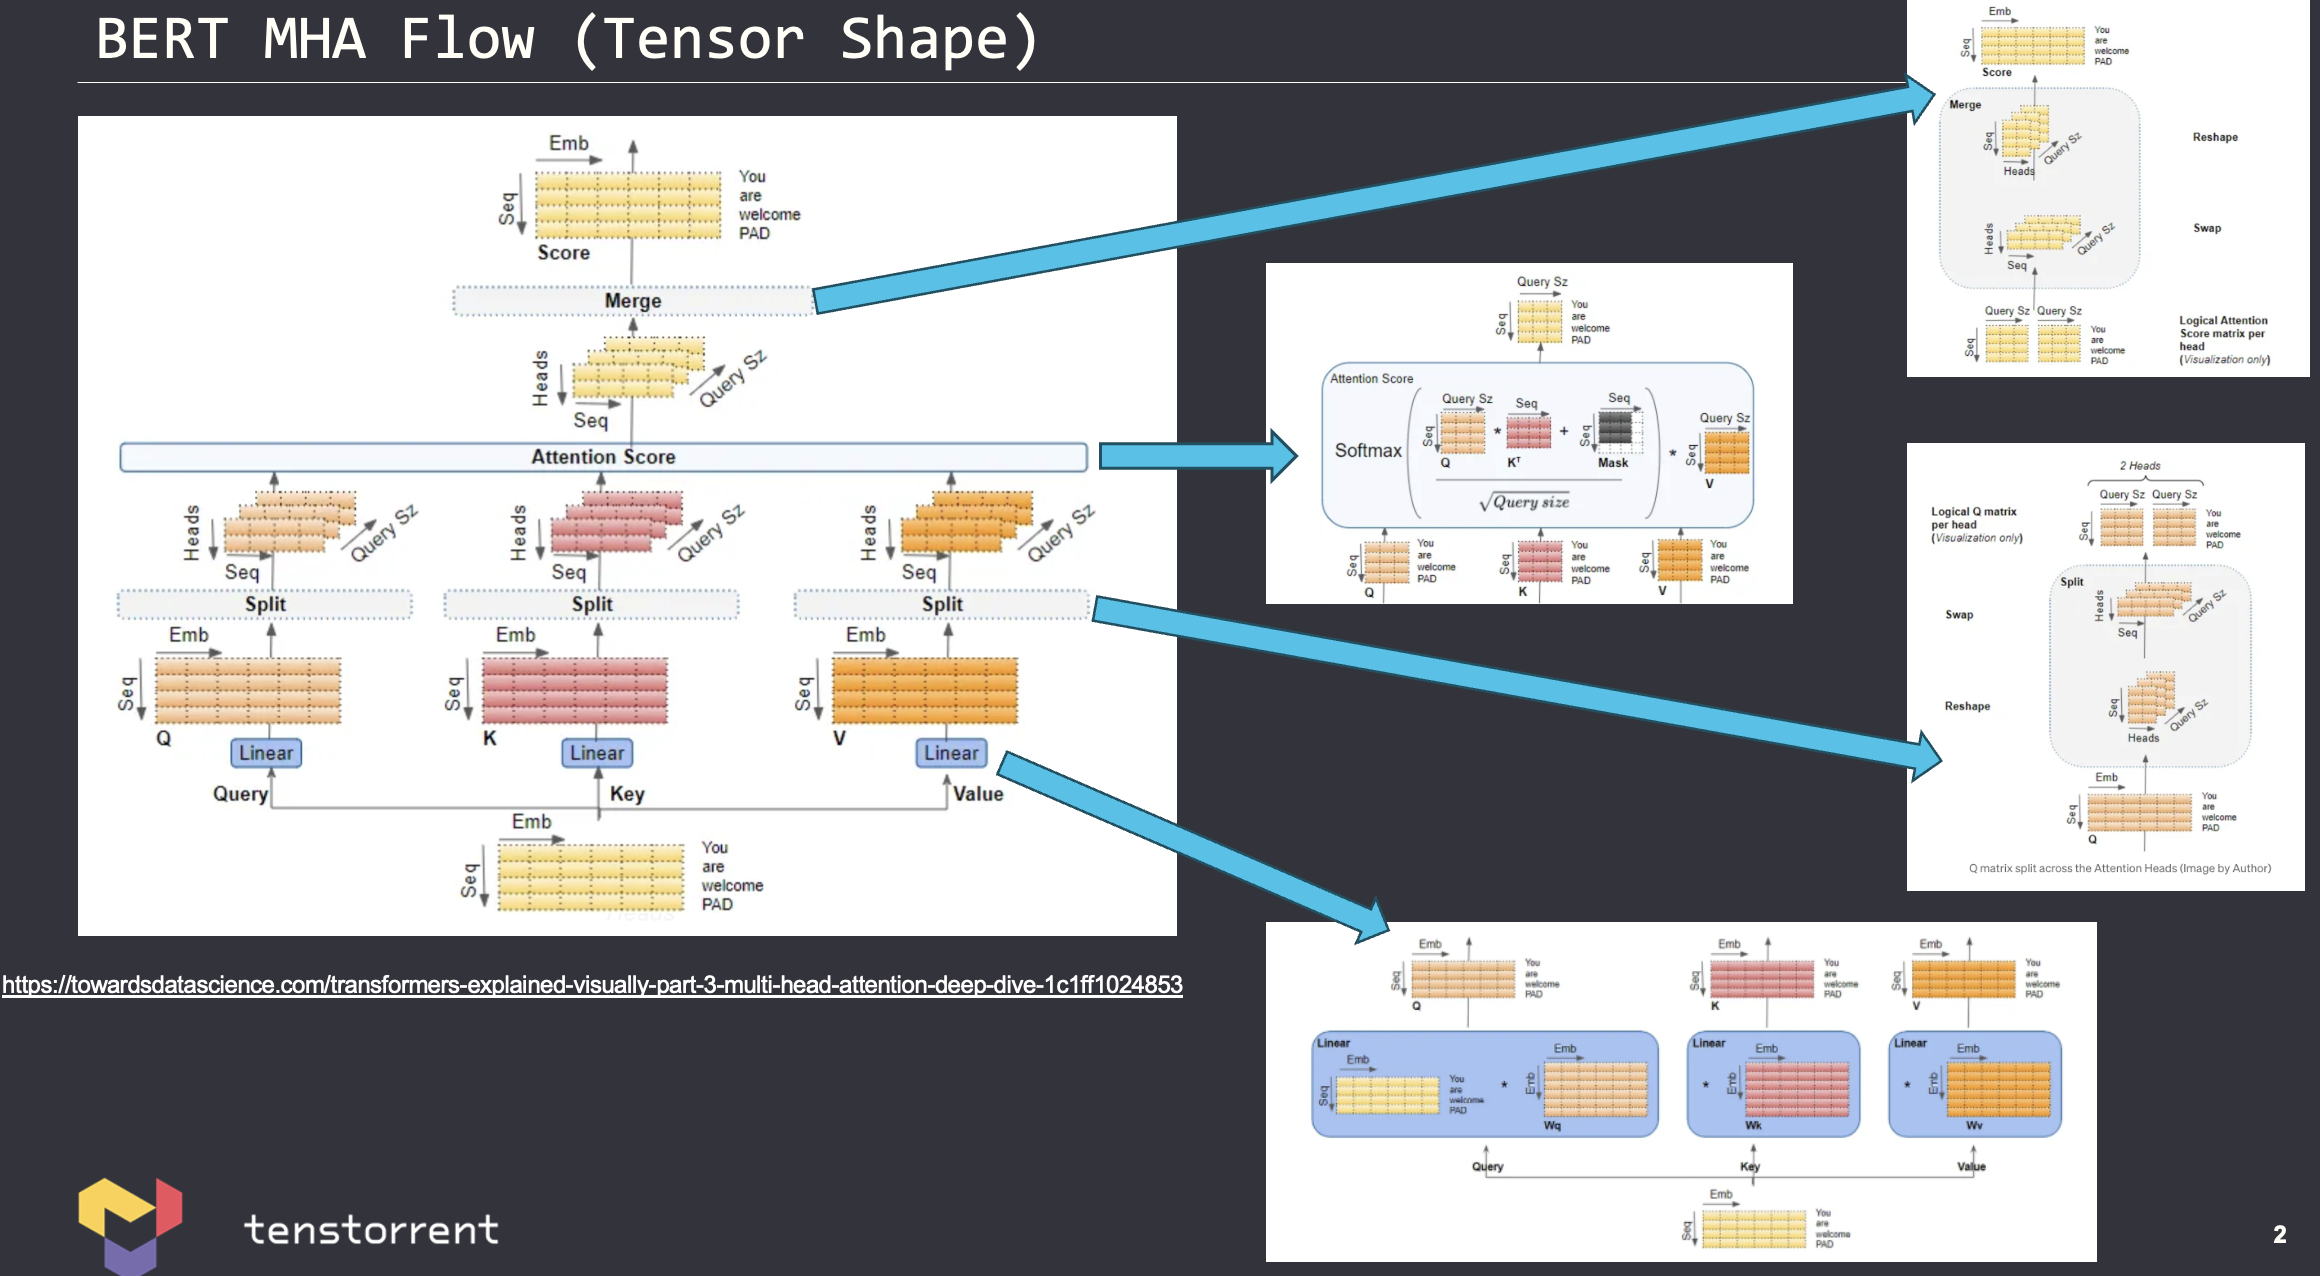

In [24]:
# MHA overview: Tensor processing and shaping
Image(filename='bert_tensor_shape.png', width=400)

### MHA OPs flow in TT-NN

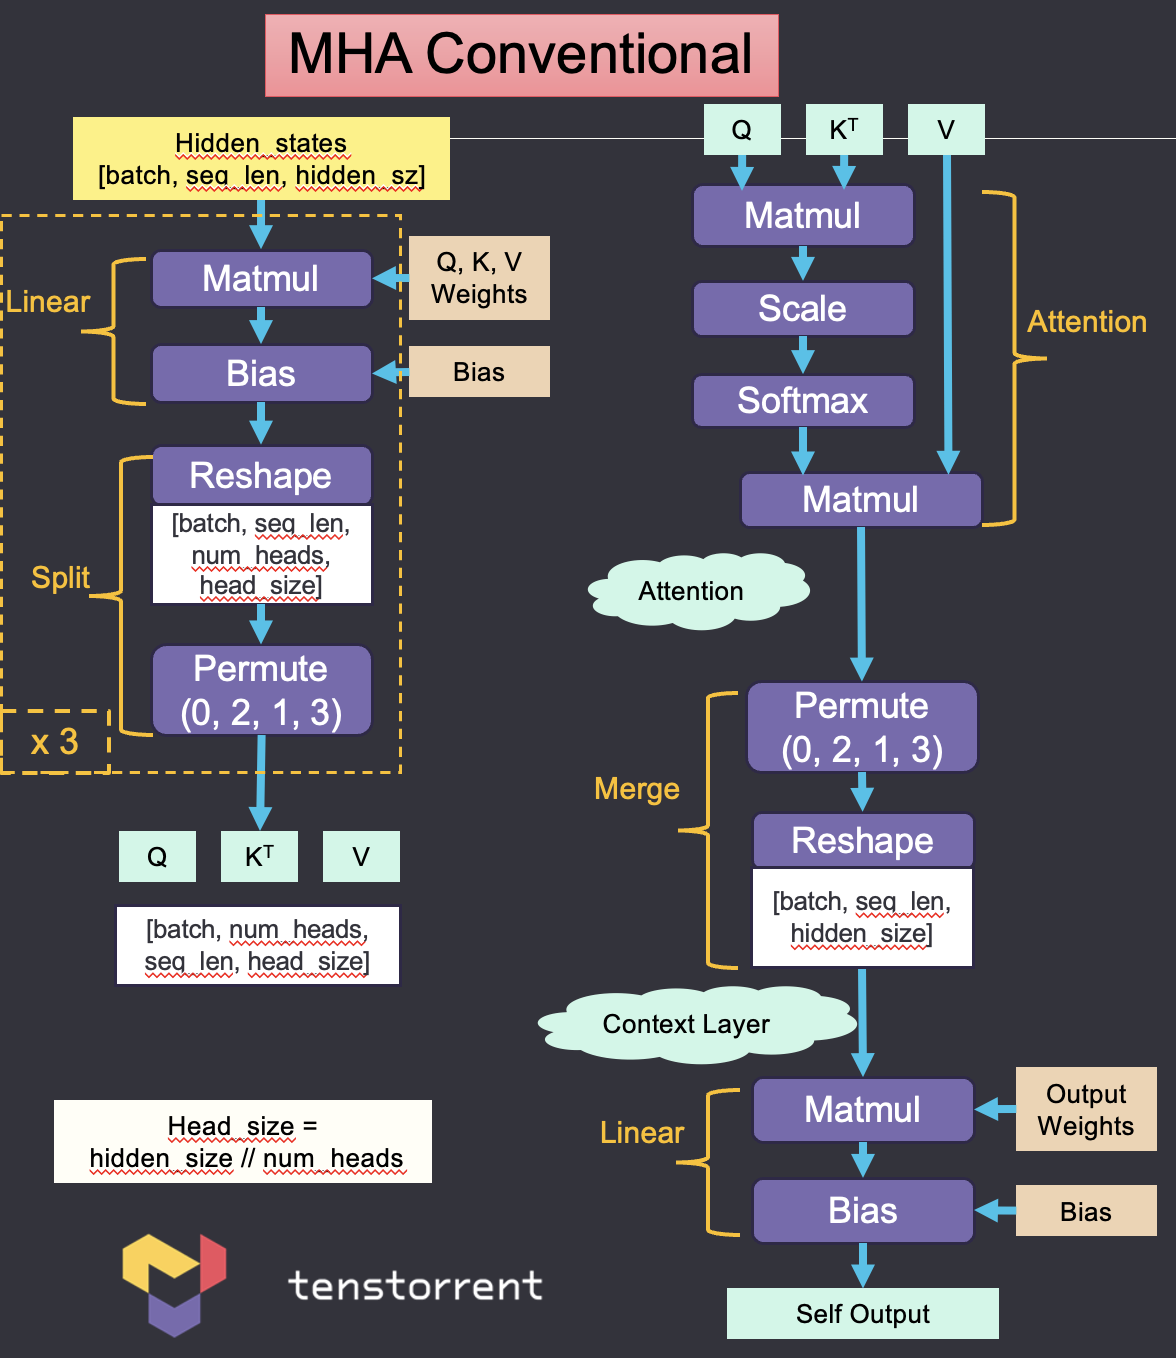

In [15]:
Image(filename='bert_ops_conventional.png', width=400)

## Write Multi-Head Attention using ttnn

Multi-head can be implemented in `torch` using just 6 operations:
1. `torch.matmul`
2. `torch.add`
3. `torch.reshape`
4. `torch.permute`
5. `torch.mul`
6. `torch.softmax`

`ttnn` provides the exact same APIs to do that and therefore multi-head attention can be implemented as shown below:

In [21]:
def multi_head_attention(
    hidden_states,
    query_weight,
    query_bias,
    key_weight,
    key_bias,
    value_weight,
    value_bias,
    output_weight,
    output_bias,
    *,
    head_size,
):
    batch_size, sequence_size, hidden_size = hidden_states.shape
    num_heads = hidden_size // head_size

    query = hidden_states @ query_weight
    query = query + query_bias
    query = ttnn.reshape(query, (batch_size, sequence_size, num_heads, head_size))
    query = ttnn.permute(query, (0, 2, 1, 3))

    key = hidden_states @ key_weight
    key = key + key_bias
    key = ttnn.reshape(key, (batch_size, sequence_size, num_heads, head_size))
    key = ttnn.permute(key, (0, 2, 3, 1))

    value = hidden_states @ value_weight
    value = value + value_bias
    value = ttnn.reshape(value, (batch_size, sequence_size, num_heads, head_size))
    value = ttnn.permute(value, (0, 2, 1, 3))

    attention_scores = query @ key
    attention_scores = attention_scores * (1 / (head_size**0.5))
    attention_probs = ttnn.softmax(attention_scores, dim=-1)

    context_layer = attention_probs @ value
    context_layer = ttnn.permute(context_layer, (0, 2, 1, 3))
    context_layer = ttnn.reshape(context_layer, (batch_size, sequence_size, hidden_size))

    self_output = context_layer @ output_weight
    self_output = self_output + output_bias

    return self_output

## Write optimized version of Multi-Head Attention

Optimized version of the multi-head attention can be written by:
- Tilizing all of the tensors ahead of time
- Using more performant matmuls that fuse bias and specify the number of cores they execute on
- Putting every tensor into L1
- Using bfloat8_b data_type
- Using custom `nlp` operations instead of `ttnn.permute` and `ttnn.reshape`

`ttnn.deallocate` calls are needed because otherwise, the cores on the device will run out of the L1 memory

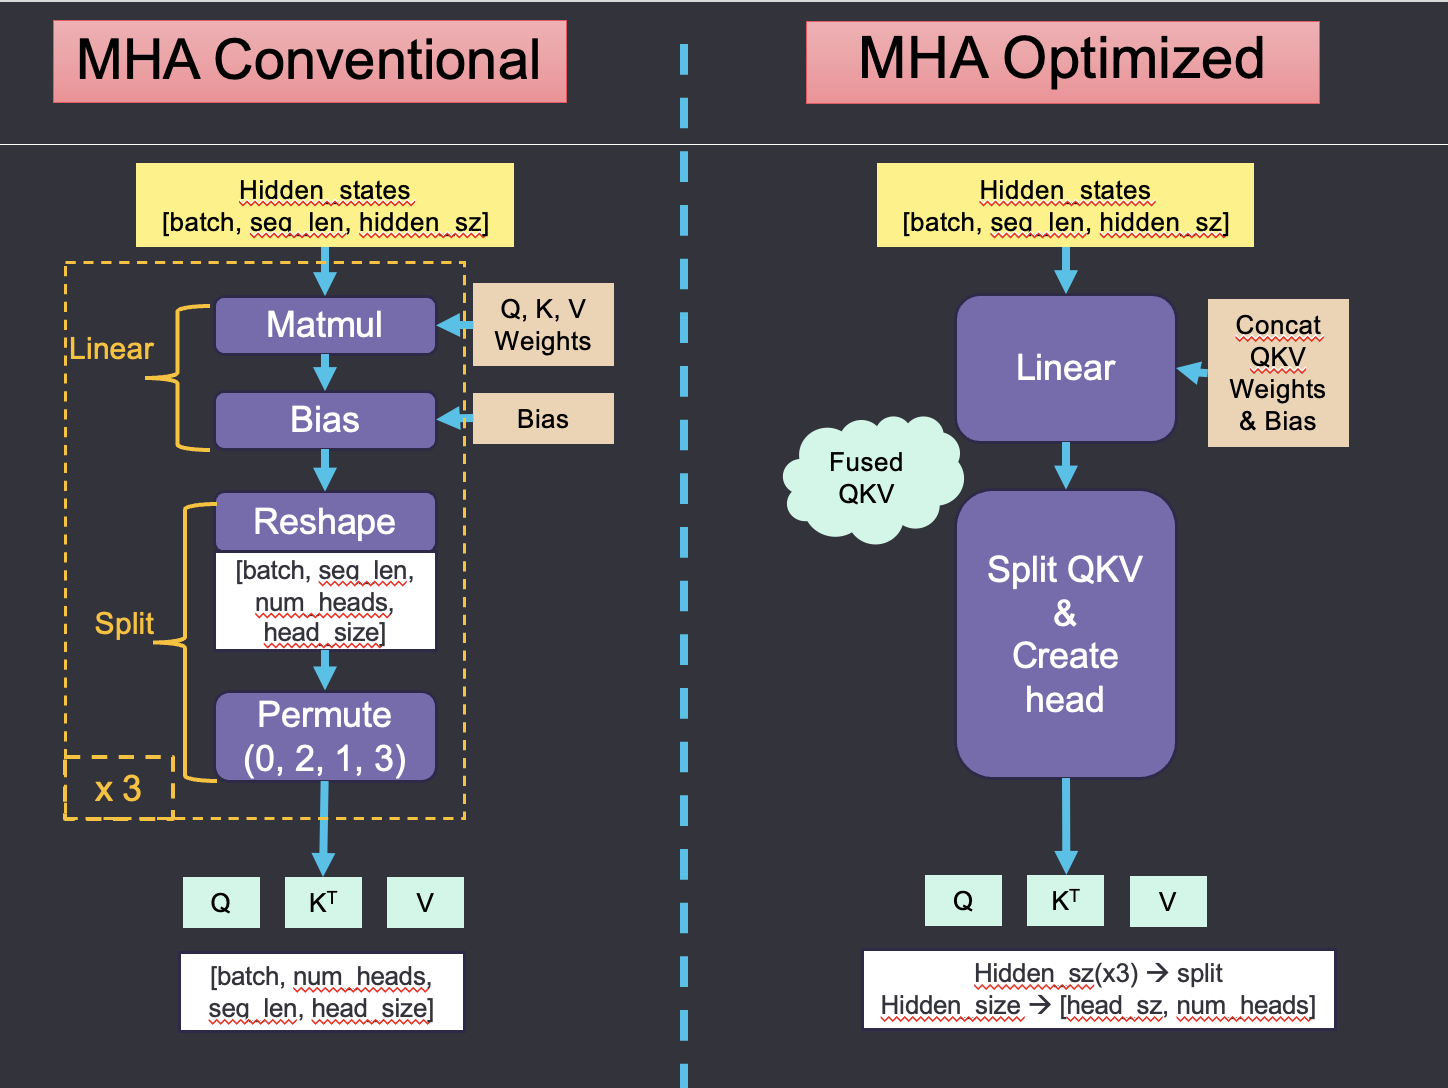

In [18]:
Image(filename='bert_ops_optim_qkv_fuse.png', width=400)

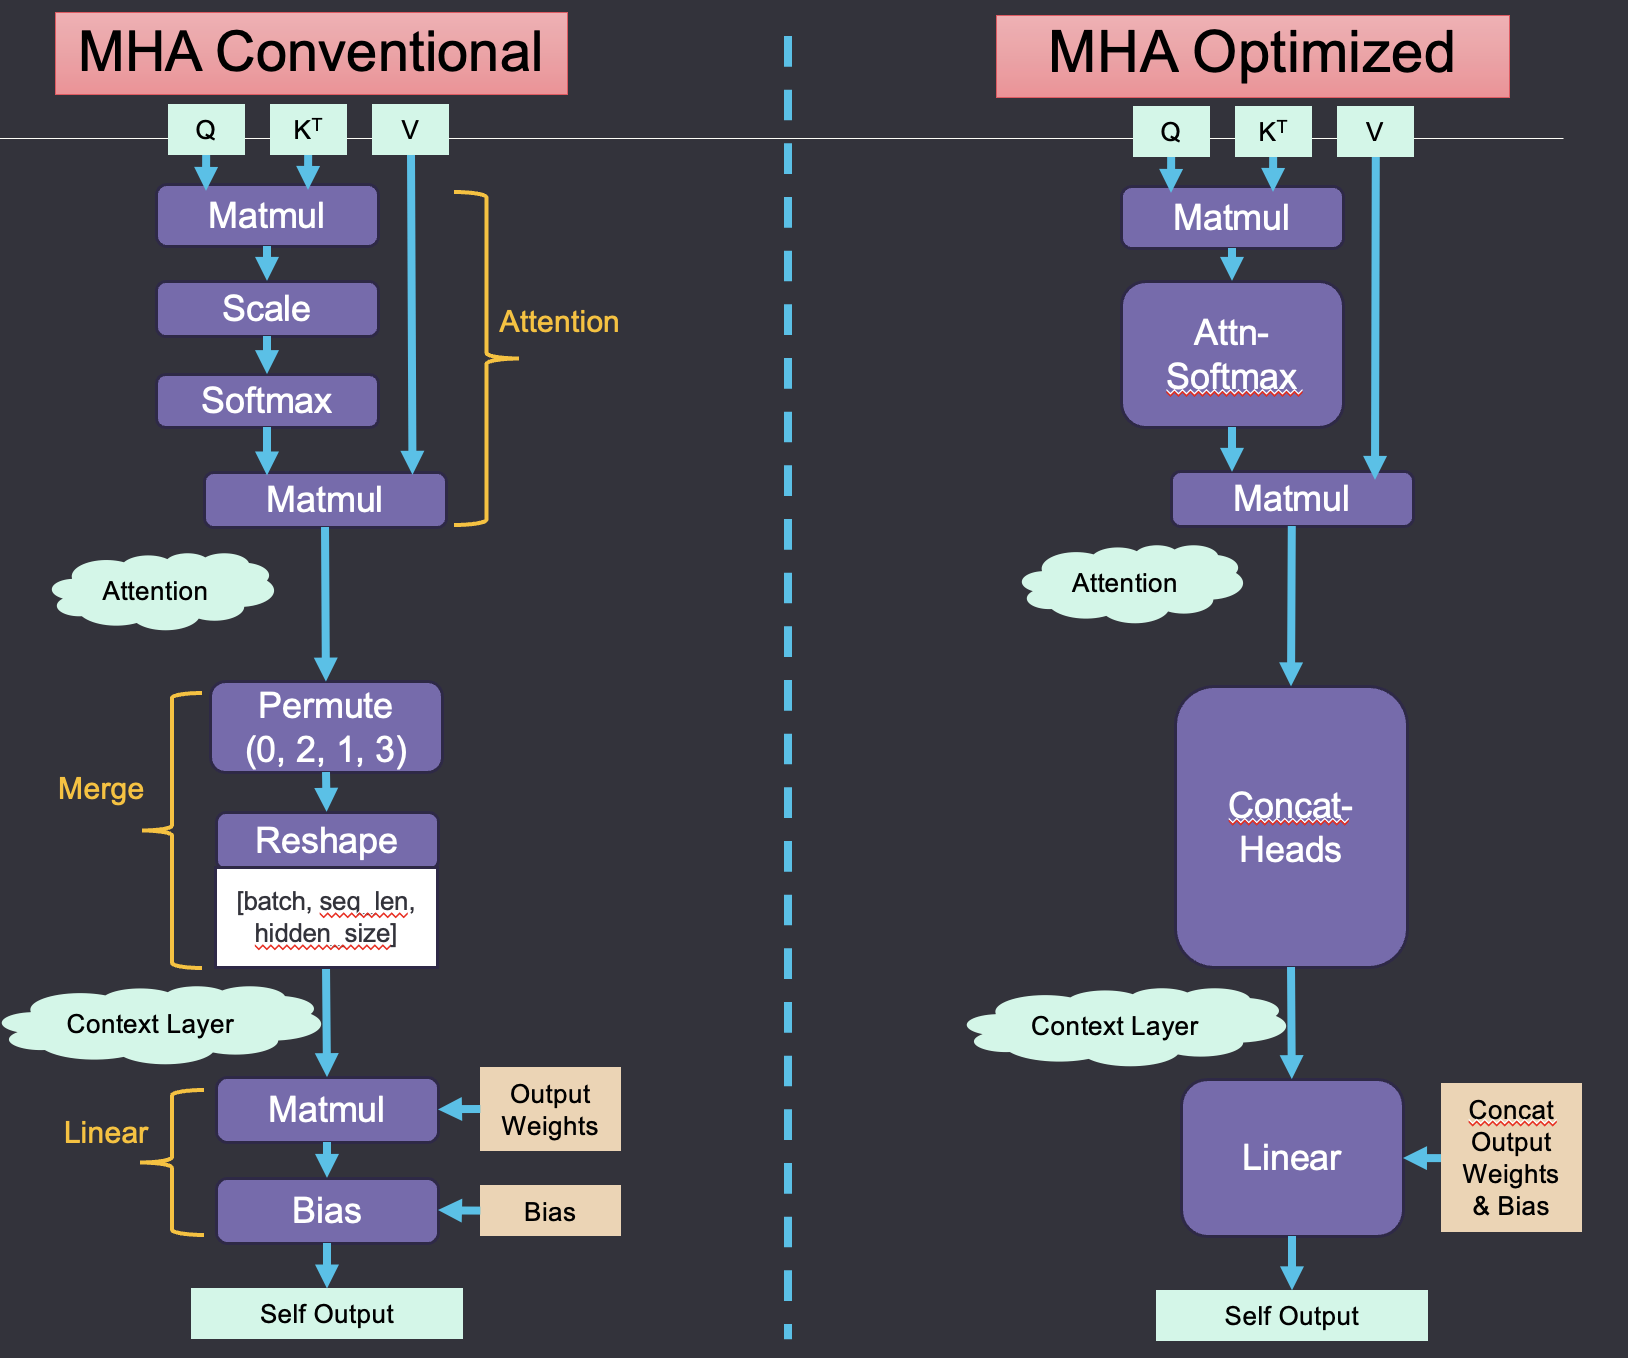

In [19]:
Image(filename='bert_ops_optim_attention.png', width=400)